In [1]:
from chromatic_fitting import *
from pymc3 import Normal, Uniform, Model, HalfNormal,Deterministic,  plot_trace, sample_prior_predictive, sample_posterior_predictive
from pymc3_ext import eval_in_model, optimize, sample, ParameterGroup
from exoplanet import QuadLimbDark, ImpactParameter

plt.matplotlib.style.use('default')

Running on Python v3.8.13 (default, Mar 28 2022, 06:13:39) 
[Clang 12.0.0 ]
Running on numpy v1.22.1


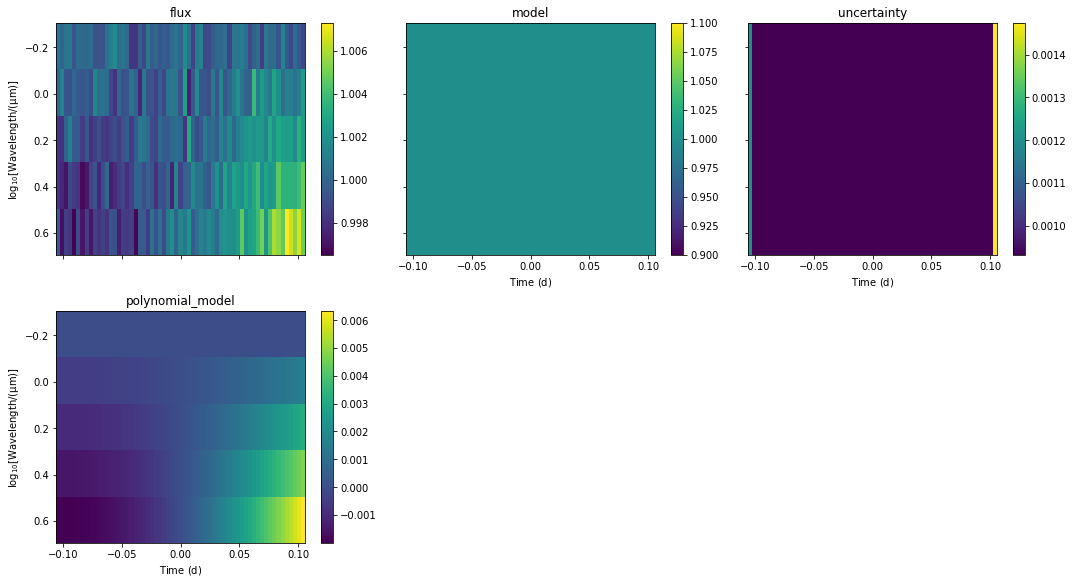

In [2]:
# create simulated rainbow
r = SimulatedRainbow(dt=1 * u.minute, R=50).inject_noise(signal_to_noise=100)
# bin:
rbin5 = r.bin(nwavelengths=int(r.nwave/5), dt=5 * u.minute)

# create wavelength-dep linear + constant model:
poly = [(0.05*i*(rbin5.time.to_value("day")**2)) + (0.01*i*rbin5.time.to_value("day")) for i in range(rbin5.nwave)]

# add this model to the Rainbow
rp = rbin5._create_copy()
rp.flux = rp.flux + poly
rp.fluxlike['polynomial_model'] = np.array(poly)
rp.imshow_quantities();

In [3]:
# set up polynomial model:
b = PolynomialModel(degree=2)
b.initialize_empty_model()
b.setup_parameters(
    p_0 = 1.0,
    p_1 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=0),
    p_2 = WavelikeFitted(Uniform,testval=0.01,upper=1,lower=0)
)

# print a summary of all params:
b.summarize_parameters()

polynomial_p_0 =
  <🧮 Fixed | 1.0 🧮>

polynomial_p_1 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=0, name='p_1') for each wavelength 🧮>

polynomial_p_2 =
  <🧮 WavelikeFitted Uniform(testval=0.01, upper=1, lower=0, name='p_2') for each wavelength 🧮>



(we need to be careful (in this version!) with the baseline in the transit model and a constant term in the
polynomial model - we don't want to have 2 fitted offset terms!)

In [4]:
# setup model the same way as for the transit model!:
b.attach_data(rp)
b.setup_lightcurves()
b.setup_likelihood()

In [5]:
b.pymc3_model

In [6]:
b.sample()
b.summarize(round_to=7, fmt='wide')


🌈 Warning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_2_w4, p_1_w4, p_2_w3, p_1_w3, p_2_w2, p_1_w2, p_2_w1, p_1_w1, p_2_w0, p_1_w0]



🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppf
🌈 Warning: overflow encountered in _beta_ppfSampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


            mean        sd        hdi_3%   hdi_97%  mcse_mean   mcse_sd  \
p_1_w0  0.001252  0.001007  4.000000e-07  0.003069   0.000016  0.000011   
p_2_w0  0.020862  0.015160  3.680000e-05  0.047494   0.000232  0.000164   
p_1_w1  0.009461  0.002053  5.591700e-03  0.013323   0.000039  0.000027   
p_2_w1  0.084857  0.024290  3.885460e-02  0.130610   0.000453  0.000320   
p_1_w2  0.020109  0.001973  1.614010e-02  0.023470   0.000031  0.000022   
p_2_w2  0.103712  0.025847  5.661180e-02  0.153396   0.000450  0.000318   
p_1_w3  0.031671  0.001979  2.789080e-02  0.035207   0.000033  0.000023   
p_2_w3  0.100339  0.024635  5.581220e-02  0.147192   0.000430  0.000304   
p_1_w4  0.041639  0.002001  3.779600e-02  0.045296   0.000033  0.000024   
p_2_w4  0.219117  0.024981  1.702640e-01  0.265741   0.000448  0.000317   

           ess_bulk     ess_tail     r_hat  
p_1_w0  2391.674453  1389.134290  1.002234  
p_2_w0  2914.702241  1591.335464  1.000424  
p_1_w1  2885.511761  1440.466442  0.999


🌈 Warning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample

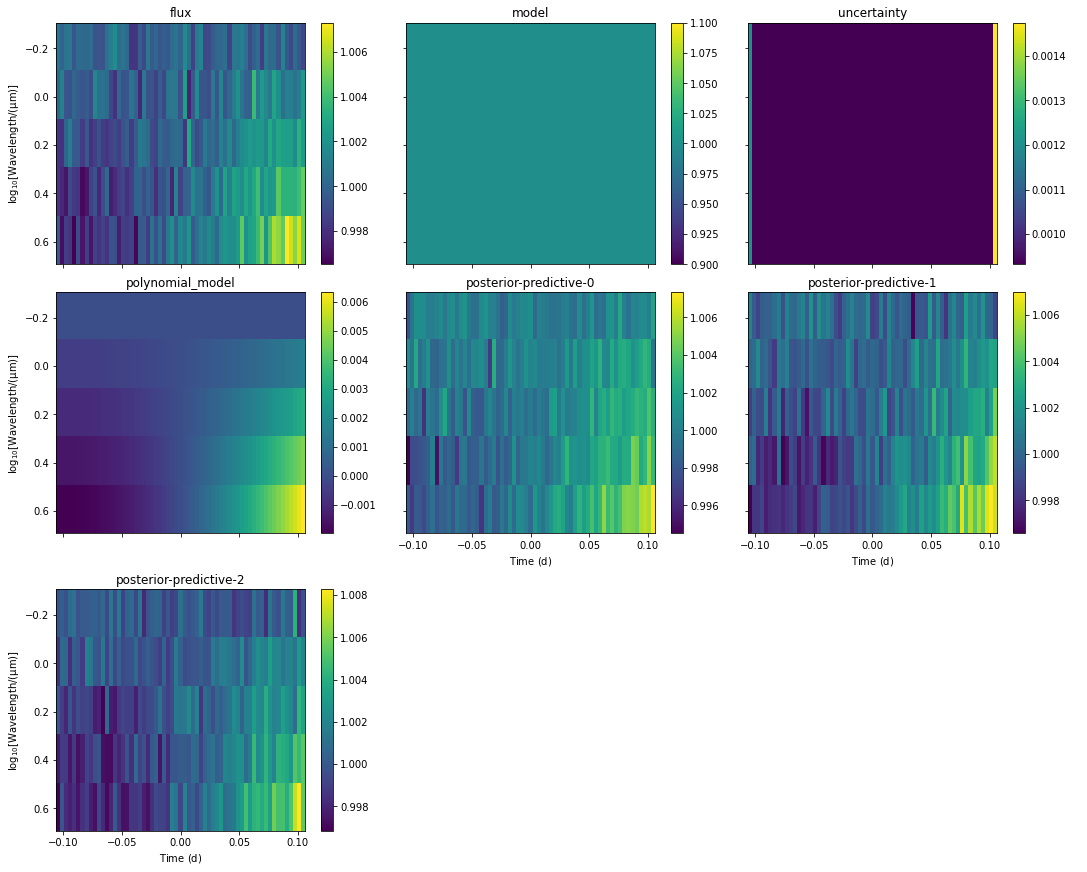

In [7]:
b.plot_posteriors()

We can always subtract our polynomial model to look at the residuals:

In [8]:
b.data.fluxlike['residuals-0'] = b.data.fluxlike['posterior-predictive-0'] - poly - 1.0

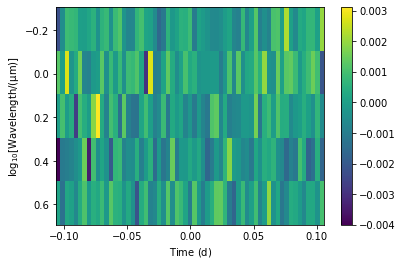

In [9]:
b.data.imshow(quantity='residuals-0');

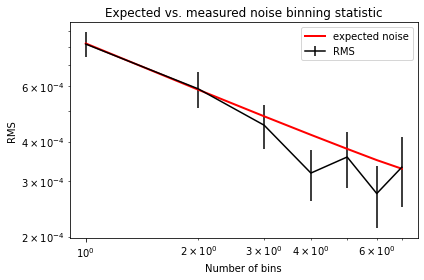

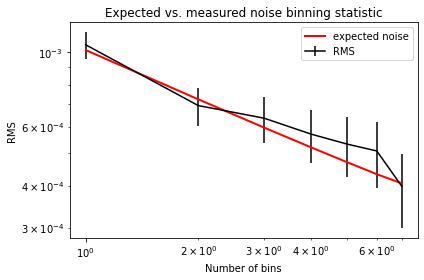

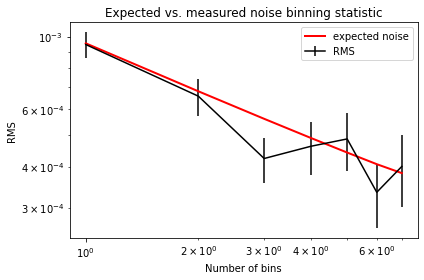

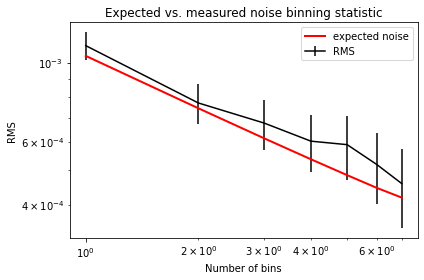

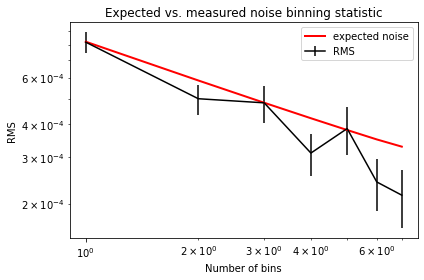

In [14]:
for i in range(5):
    red_noise, white_noise, beta = noise_calculator(b.data.fluxlike['residuals-0'][i])

In [16]:
red_noise, white_noise, beta

(0.000803490843297551, 0.00015819821746630047, 1.2037902632181599)